# Моделирование Монте-Карло с помощью Python

<a href="https://colab.research.google.com/github/dm-fedorov/pandas_basic/blob/master/%D0%A2%D0%B5%D0%BF%D0%BB%D0%B8%D1%86%D0%B0/5.%20%D0%9F%D0%B0%D1%80%D0%BA%D0%B8.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory" target="_blank"></a>

## Введение

Существует множество моделей, которые могут использоваться для решения задачи прогнозирования. Одним из подходов, который может дать лучшее понимание диапазона возможных результатов и помочь избежать ["ошибки средних"](https://hbr.org/2002/11/the-flaw-of-averages), является [*моделирование методом Монте-Карло*](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9C%D0%BE%D0%BD%D1%82%D0%B5-%D0%9A%D0%B0%D1%80%D0%BB%D0%BE). 

В оставшейся части этой статьи будет описано, как использовать *Python* с *pandas* и *NumPy* для прогнозирования диапазона потенциальных значений для бюджета комиссионных с продаж с помощью моделирования Монте-Карло. 

> Оригинал статьи Криса [тут](https://pbpython.com/monte-carlo.html)

## Проблема

В следующем примере попытаемся предсказать, сколько денег необходимо выделить на комиссионные с продаж (поощрительные выплаты) в следующем году. Эта задача хорошо подходит для моделирования, т.к. у нас есть определенная формула для расчета комиссионных, и некоторый опыт с выплатой комиссионных за предыдущие годы.

Эта проблема также важна с точки зрения бизнеса. Комиссионные с продаж могут оказаться большими расходами, и важно их правильно спланировать. Кроме того, использование моделирования Монте-Карло является относительно простым.

Примерная комиссия с продаж будет выглядеть следующим образом для отдела продаж из `5` человек:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_1.png?raw=True)

В этом примере комиссия рассчитывается по следующей формуле:

`Commission Amount (Сумма комиссии) = Actual Sales (Фактические продажи) * Commission Rate (Ставка комиссионного вознаграждения)`

Ставка комиссии основана на этой таблице `Percent To Plan (Процент к плану)`:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_4.png?raw=True)

Прежде чем строить модель и запускать симуляцию, давайте рассмотрим простой подход к прогнозированию комиссионных расходов на следующий год.

## Наивный (Naïve) подход к проблеме

Представьте, что ваша задача в роли аналитика Эми или Энди состоит в том, чтобы сообщить финансовому отделу, сколько в бюджете необходимо выделить комиссионных с продаж на следующий год. Один из подходов заключается в том, чтобы предположить, что каждый выполняет `100%` своей цели и получает `4%` комиссионных. 

Вставка этих значений в *Excel* дает следующее:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_2.png?raw=True)

Представьте, что вы представляете это финансовому отделу, и они говорят: "У нас никогда не бывает одинаковых комиссионных. Нам нужна более точная модель". 

Во втором раунде вы можете попробовать несколько диапазонов:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_5.png?raw=True)

Или еще один:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_6.png?raw=True)

Теперь у вас есть немного больше информации. На этот раз финансовый отдел говорит: "Этот диапазон полезен, но каково ваше доверие к нему? Кроме того, нам нужно, чтобы вы провели расчет для отдела продаж из 500 человек и смоделировали несколько различных ставок, чтобы определить сумму бюджета". Хммм… 

Этот простой подход иллюстрирует основной итерационный метод моделирования Монте-Карло. Вы повторяете процесс много раз, чтобы определить диапазон возможных значений комиссионных за год. Сделать это вручную сложно. К счастью, с Python процесс значительно упрощается.

## Монте-Карло

Теперь, когда мы обсудили проблему на высоком уровне, посмотрим, как метод Монте-Карло может быть применим для прогнозирования комиссионных расходов на следующий год. На простейшем уровне анализ (или моделирование) Монте-Карло выполняет множество сценариев с различными случайными входными данными и обобщение распределения результатов.

Используя анализ комиссионных, мы можем продолжить ручной процесс, который мы начали выше, но запустить программу `100` или даже `1000` раз, и получим распределение потенциальных сумм комиссии. Это распределение может информировать о вероятности того, что расходы будут в пределах определенного окна. В конце концов, это прогноз, поэтому мы, скорее всего, никогда его точно не предскажем. Мы можем разработать более информативное представление о потенциальном риске недостаточного или завышенного бюджета.

Запуск моделирования Монте-Карло состоит из двух компонентов:

- уравнение для оценки;
- случайные величины для входа.

Уравнение мы рассмотрели выше. Теперь нужно подумать о том, как заполнить случайные величины.

Один из простых подходов - взять случайное число от `0%` до `200%` (представляющее нашу интуицию о ставках комиссионных). Однако, поскольку мы выплачиваем комиссионные каждый год, мы понимаем нашу проблему немного подробнее и можем использовать эти предварительные знания для построения более точной модели.

Поскольку мы выплачивали комиссионные в течение нескольких лет, мы можем взглянуть на типичное историческое распределение целевого процента:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/monte_carlo_image_hist_pct.png?raw=True)

Это распределение выглядит как нормальное распределение со средним значением `100%` и стандартным отклонением `10%`. Это понимание полезно, потому что мы можем моделировать наше распределение входных переменных так, чтобы оно было похоже на реальный опыт.

Если вас интересуют дополнительные детали для оценки типа распределения, я рекомендую [эту статью](https://www.mikulskibartosz.name/monte-carlo-simulation-in-python/).

## Построение модели Python

Можем использовать *pandas* для построения модели, которая воспроизводит расчет таблицы *Excel*. Существуют и другие подходы к построению моделей Монте-Карло, но я считаю, что с помощью *pandas* легче понять, если вы ранее работали с *Excel*. 

Выполним импорт и установим стиль для графиков:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

Для этой модели мы будем использовать генерацию случайных чисел из *NumPy*. Преимущество *NumPy* заключается в том, что существует [несколько генераторов случайных чисел](https://numpy.org/doc/stable/reference/random/index.html), которые могут создавать случайные выборки на основе заранее заданного распределения.

Как сказано выше, мы знаем, что исторический процент к целевой производительности сосредоточен вокруг среднего значения `100%` и стандартного отклонения `10%`. Давайте определим эти переменные, а также количество торговых представителей и число симуляций, которое мы моделируем:

In [2]:
avg = 1
std_dev = .1
num_reps = 500
num_simulations = 1000

Теперь мы можем использовать *NumPy* для создания списка процентов, который будет воспроизводить историческое нормальное распределение:

In [3]:
pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

В этом примере я решил округлить результат до двух знаков после запятой, чтобы было легче увидеть границы. 

Вот как выглядят первые `10` пунктов:

In [4]:
pct_to_target[:10]

array([0.92, 1.15, 0.98, 1.13, 0.98, 1.  , 0.94, 1.11, 1.19, 1.07])

Это хорошая проверка, чтобы убедиться, что диапазоны соответствуют ожиданиям.

Поскольку мы пытаемся улучшить наш простой подход, то будем придерживаться нормального распределения целевого процента. Однако, используя *NumPy*, можно настроить и использовать другое распределение для будущих моделей, если это необходимо. Предупреждаю, что не надо использовать другие модели, не понимая их и, как они применимы к вашей ситуации.

Есть еще одно значение, которое нужно смоделировать, и это фактическая цель продаж. Чтобы проиллюстрировать другое распределение, предположим, что наше целевое распределение продаж выглядит примерно так:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/monte_carlo_sales_target.png?raw=True)

Это определенно ненормальное распределение. Это распределение показывает нам, что цели продаж устанавливаются в `1` из `5` сегментов, и частота уменьшается с увеличением суммы. Такое распределение может свидетельствовать об очень простом процессе установления целевых показателей, при котором отдельные лица делятся на определенные группы и получают целевые показатели последовательно в зависимости от их срока пребывания (tenure), размера территории или воронки продаж.

Для этого примера будем использовать равномерное распределение, но назначим более низкие уровни вероятности для некоторых значений.

Вот как мы можем это построить, используя [`numpy.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html):

In [5]:
sales_target_values = [75_000, 100_000, 200_000, 300_000, 400_000, 500_000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)

По общему признанию, это несколько надуманный пример, но я хотел показать, как различные распределения могут быть включены в модель. 

Теперь, когда мы знаем, как создать два входных распределения, давайте создадим фрейм данных (*dataframe*) *pandas*:

In [6]:
df = pd.DataFrame(index=range(num_reps), 
                  data={'Pct_To_Target': pct_to_target,
                        'Sales_Target': sales_target})

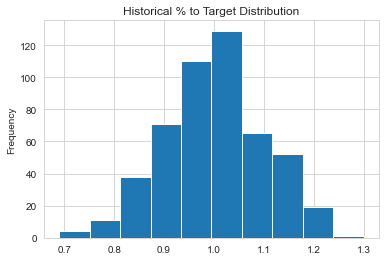

In [7]:
# Простая гистограмма для подтверждения распределения
df['Pct_To_Target'].plot(kind='hist', title='Historical % to Target Distribution');

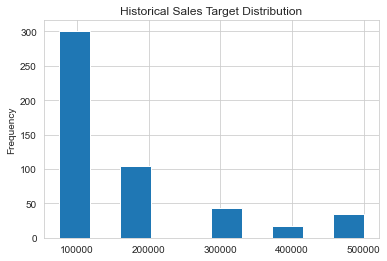

In [8]:
# Посмотрите на целевое распределение продаж
df['Sales_Target'].plot(kind='hist', 
                        title='Historical Sales Target Distribution');

In [9]:
# Фактическая сумма продаж
df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

Вот как выглядит новый фрейм данных:

In [10]:
df.head()

,Pct_To_Target,Sales_Target,Sales
0,0.92,300000,276000.0
1,1.15,75000,86250.0
2,0.98,200000,196000.0
3,1.13,100000,113000.0
4,0.98,100000,98000.0


Вы могли заметить, что я проделал небольшой трюк, чтобы вычислить фактическую сумму продаж (*actual sales amount*). Для этой задачи фактическая сумма продаж может сильно меняться с годами, но распределение производительности остается удивительно стабильным. Поэтому я использую случайные распределения для генерации исходных данных и поддержки фактических продаж.

Последний фрагмент кода, который нужно создать, - это способ сопоставления `Pct_To_Target` со ставкой комиссии. 

Вот функция:

In [11]:
def calc_commission_rate(x):
    """ Вернуть комиссию по таблице:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    if x <= .90:
        return .02
    if x <= .99:
        return .03
    else:
        return .04

> Дополнительное преимущество использования *Python* вместо *Excel* заключается в том, что мы можем создать гораздо более сложную логику, которую легче понять, чем если бы мы пытались создать сложный вложенный оператор *if* в *Excel*.

Теперь мы создаем ставку комиссии и умножаем ее на продажи:

In [12]:
df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)

In [13]:
# Рассчитайте комиссии
df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

Результат похож на модель, построенную в *Excel*:

In [14]:
df.head()

,Pct_To_Target,Sales_Target,Sales,Commission_Rate,Commission_Amount
0,0.92,300000,276000.0,0.03,8280.0
1,1.15,75000,86250.0,0.04,3450.0
2,0.98,200000,196000.0,0.03,5880.0
3,1.13,100000,113000.0,0.04,4520.0
4,0.98,100000,98000.0,0.03,2940.0


Просуммируем значения в каждом из столбцов (нужный нам результат в столбце `Commission_Amount`):

In [15]:
df['Sales'].sum(), df['Commission_Amount'].sum(), df['Sales_Target'].sum()

(84275500.0, 2887310.0, 84225000)

Вот и все!

Мы воспроизвели модель, аналогичную той, что сделали в *Excel*, но использовали несколько более сложных распределений, чем просто добавление в задачу набора случайных чисел.

## Запустим цикл

Настоящая "магия" моделирования Монте-Карло заключается в том, что, если мы запускаем моделирование много раз, то начинаем формировать картину вероятного распределения результатов. В *Excel* понадобится *VBA* для выполнения нескольких итераций. В *Python* мы можем использовать `цикл for` для запуска любого количества симуляций.

Помимо запуска каждой симуляции, сохраняем результаты, которые нам интересны, в списке, который превратим во фрейм данных для дальнейшего анализа распределения результатов.

Вот полный код цикла:

In [16]:
# Определите список, чтобы сохранить результаты каждой симуляции, которую хотим проанализировать
all_stats = []

# Пройдите через множество симуляций
for i in range(num_simulations):

    # Выберите случайные входные данные для целей продаж и процент для целей
    sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

    # Создайте фрейм данных на основе входных значений и количества повторений
    df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                                   'Sales_Target': sales_target})

    # Вернитесь к количеству продаж, используя процент для целевой ставки
    df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

    # Определите ставку комиссии и рассчитайте ее
    df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
    df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

    # Мы хотим отслеживать продажи, суммы комиссионных и целевые показатели продаж по всем симуляциям
    all_stats.append([df['Sales'].sum().round(0),
                      df['Commission_Amount'].sum().round(0),
                      df['Sales_Target'].sum().round(0)])

Результаты `1 миллиона` симуляций не всегда более полезны, чем `10 000`. Попробуйте разное количества и посмотрите, как изменится результат.

Чтобы проанализировать результаты моделирования, я построю фрейм данных из `all_stats`:

In [17]:
results_df = pd.DataFrame.from_records(all_stats, columns=['Sales',
                                                           'Commission_Amount',
                                                           'Sales_Target'])

Теперь легко увидеть, как выглядит диапазон результатов:

In [18]:
results_df.describe().style.format('{:,}')

,Sales,Commission_Amount,Sales_Target
count,"1,000.0","1,000.0","1,000.0"
mean,"83,931,180.5","2,865,507.675","83,942,175.0"
std,"2,730,459.8230682616","105,217.49947883165","2,661,233.794630732"
min,"74,895,750.0","2,529,560.0","75,150,000.0"
25%,"82,026,750.0","2,795,261.25","81,975,000.0"
50%,"83,817,750.0","2,862,944.0","83,862,500.0"
75%,"85,761,250.0","2,935,127.5","85,775,000.0"
max,"93,293,250.0","3,248,390.0","92,925,000.0"


Графически это выглядит так:

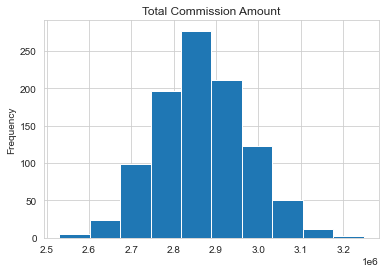

In [19]:
results_df['Commission_Amount'].plot(kind='hist', 
                                     title="Total Commission Amount");

Итак, о чем говорит эта диаграмма и результат описания? 

Видим, что средние комиссионные расходы составляют `2,85 миллиона долларов`, а стандартное отклонение составляет `103 тысячи долларов`. Мы также видим, что размер комиссионных может составлять от `2,5` до `3,2 млн долларов`.

Исходя из этих результатов, насколько вы уверены, что расходы на комиссионные будут меньше `3 миллионов долларов`? Или, если кто-то скажет: "Давайте выделим только `2,7 миллиона долларов`", почувствуете ли вы, что ваши расходы будут меньше этой суммы? Возможно нет.

В этом заключается одно из преимуществ моделирования Монте-Карло. Вы лучше понимаете распределение вероятных результатов и можете использовать эти знания, а также свою деловую хватку, чтобы сделать обоснованную оценку.

Другая ценность этой модели состоит в том, что вы можете моделировать множество различных предположений и смотреть, что происходит. Вот несколько простых изменений, которые вы можете внести, чтобы увидеть, как меняются результаты:

- увеличить максимальную комиссию до 5%;
- уменьшите количество продавцов;
- измените ожидаемое стандартное отклонение на большее значение;
- изменить распределение целей.

Теперь, когда модель создана, внести эти изменения так же просто, как настроить несколько переменных и повторно запустить код. 

Еще одно наблюдение, касающееся моделирования методом Монте-Карло, заключается в том, что его относительно легко объяснить конечному пользователю. Человек, получающий эту оценку, может не иметь глубоких математических знаний, но способен интуитивно понять, что делает это моделирование и как оценить вероятность диапазона возможных результатов.

Наконец, я думаю, что показанный здесь подход легче понять и воспроизвести, чем некоторые решения *Excel*, с которыми вы можете столкнуться. 

## Заключение

*Моделирование методом Монте-Карло* - полезный инструмент для прогнозирования будущих результатов путем многократного вычисления формулы с различными случайными входными данными. 

Дополнительным преимуществом *Python* является то, что аналитики могут запускать множество сценариев, изменяя исходные данные, и переходить к гораздо более сложным моделям в будущем, если возникнут потребности. Наконец, результатами можно поделиться с нетехническими пользователями и облегчить обсуждение неопределенности конечных результатов.

### Обновления 19 марта 2019 г. 
> Основываясь на [комментариях Reddit](https://www.reddit.com/r/Python/comments/arxwkm/monte_carlo_simulation_with_python/), я сделал еще одну [реализацию](https://colab.research.google.com/github/chris1610/pbpython/blob/master/notebooks/Monte_Carlo_Simulationv2.ipynb), которая работает быстрее.